In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from patsy import dmatrices, dmatrix
from difflib import SequenceMatcher
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
from scipy.stats import poisson

In [2]:
# Poisson exploration
p_random = np.random.poisson(2, 10000)
p_mean = np.mean(p_random)
p_std = np.std(p_random)
p_norm = [(i - p_mean)/p_std for i in p_random]

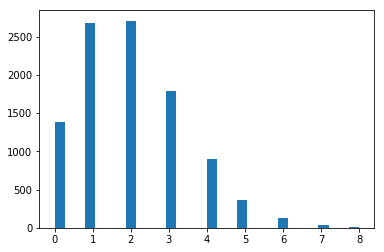

In [3]:
plt.hist(p_random, 30);

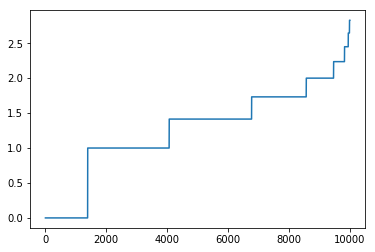

In [4]:
plt.plot(sorted(np.power(p_random, 1/2)));

In [ ]:
# Load pickles

file = open('final_df_pickle_v1.0', 'rb')
final_df = pickle.load(file)
file.close()

file = open('actor_bday_v1.0', 'rb')
bday_dict = pickle.load(file)
file.close()

In [ ]:
# more_bdays_df = pd.read_csv("name.basics.tsv", sep="\t")

# file = open('more_bdays_df', 'wb')
# pickle.dump(more_bdays_df, file)
# file.close()

In [ ]:
file = open('more_bdays_df', 'rb')
more_bdays_df = pickle.load(file)
file.close()
more_bdays_df = more_bdays_df[['primaryName','birthYear']]

In [ ]:
master_bdays_df = more_bdays_df[more_bdays_df['primaryName'].isin(list(set(final_df['star'])))]
master_bdays_df.shape

(2018, 2)

In [ ]:
master_bdays_df[master_bdays_df['primaryName']=='Tom Cruise'].iloc[0]['birthYear'].isnumeric()

True

In [ ]:
def get_bday(star):
    try:
        counter = 0
        while master_bdays_df[master_bdays_df['primaryName']==star].iloc[counter]['birthYear'].isnumeric() != True:
            counter += 1
        return master_bdays_df[master_bdays_df['primaryName']==star].iloc[counter]['birthYear']
    except:
        return None

final_df['birth_year'] = final_df['star'].apply(get_bday)
print('Still missing bdays for ' + str(sum([1 for i in final_df['birth_year'].isna() if i])) + ' actors')
missing_list = final_df[final_df['birth_year'].isna()]['star']

In [ ]:
print(len(set(missing_list)))
set(missing_list)

# Drop stars with no birthdays
final_df.dropna(inplace=True)
print(final_df.shape)

# Modify 'The Conversation' movie's release month (scrape error)
final_df.loc[list(final_df[final_df['release_month']=='1974'].index)[0], 'release_month'] = 'June'

final_df.reset_index(inplace=True)

In [ ]:
# Adjust datatypes
to_numeric_cols = ['budget','imdb_rating','meta_rating','runtime','usa_gross']
for i in to_numeric_cols:
    final_df[i] = pd.DataFrame(final_df[i], dtype='float')
final_df['year'] = pd.DataFrame(final_df['year'], dtype='int')
final_df['birth_year'] = pd.DataFrame(final_df['birth_year'], dtype='int')

# Add interesting columns

final_df['profit'] = final_df['usa_gross'] - final_df['budget']
final_df['log_usa_gross'] = np.log(list(final_df['usa_gross']))
final_df['root_usa_gross'] = np.power(list(final_df['usa_gross']), 1/2)
final_df['log_budget'] = np.log(list(final_df['budget']))
final_df['root_budget'] = np.power(list(final_df['budget']), 1/10)
final_df['money_per_minute'] = final_df['root_budget']/final_df['runtime']
final_df['gross_budget_ratio'] = final_df['usa_gross'] / final_df['budget']
final_df['log_gb_ratio'] = np.log(list(final_df['gross_budget_ratio']))
final_df['root_gb_ratio'] = np.power(list(final_df['gross_budget_ratio'] + 1), 1/10)
final_df['log_gb_diff'] = final_df['log_usa_gross'] - final_df['log_budget']
final_df['age_of_star'] = final_df['year'] - final_df['birth_year']

# Narrow genres
fix_genre_dict = {'Mystery': 'Crime', 'Romance': 'Drama', 'Fantasy': 'Adventure', 
                  'Sci-Fi': 'Adventure', 'Family': 'Animation', 'Musical': 'Animation'}
fixed_genres = []
for i in final_df['genres']:
    if i in fix_genre_dict:
        fixed_genres.append(fix_genre_dict[i])
    else:
        fixed_genres.append(i)
final_df['fixed_genres'] = fixed_genres

In [ ]:
# Check out my variables
sorted_var = list(final_df['root_usa_gross'].sort_values(ascending=True))
plt.plot(sorted_var);

In [ ]:
# Replace outliers to linearize
low_cut = final_df['root_usa_gross'].quantile(0.00)
high_cut = final_df['root_usa_gross'].quantile(1.00)
for i, val in enumerate(final_df['root_usa_gross']):
    if (val <= low_cut):
        final_df.loc[i,'root_usa_gross'] = None
    elif (val >= high_cut):
        final_df.loc[i,'root_usa_gross'] = None
        
final_df.dropna(inplace=True)

# Drop everything before 1985
# final_df.drop(list(final_df[final_df['year'] < 1985].index), axis=0, inplace=True)

# Need to reset index after dropping rows otherwise when you merge the HOT encoding, the indexes are different
# final_df.reset_index(drop=True, inplace=True)

# Check out my variables post harmonization
sorted_var = list(final_df['root_usa_gross'].sort_values(ascending=True))
plt.plot(sorted_var);

In [ ]:
# Feature engineering

star_profit = final_df.groupby(by=['star','year']).mean()['root_usa_gross']
star_meta = final_df.groupby(by=['star','year']).mean()['meta_rating']
director_meta = final_df.groupby(by=['director','year']).mean()['meta_rating']

# Previous N year's box office gross of star
def get_star_power(star, year, N):
    past_bank = star_profit.loc[star].loc[year-N:year-1]
    if list(past_bank) == []:
        return 100000
    else:
        return np.mean(past_bank)

past_bank_short = []
past_bank_long = []
for i, val in enumerate(final_df['star']):
    past_bank_short.append(get_star_power(val, final_df['year'].iloc[i], 1))
    past_bank_long.append(get_star_power(val, final_df['year'].iloc[i], 3))
    
final_df['past_bank_short'] = past_bank_short
final_df['past_bank_long'] = past_bank_long

# Mean historical metascore of the director's movies in the past N years
def get_critical_acclaim(person, year, N):
    try:
        acclaim = star_meta.loc[person].loc[year-N:year-1]
    except:
        acclaim = director_meta.loc[person].loc[year-N:year-1]
    if list(acclaim) == []:
        return 4.0
    else:
        return np.mean(acclaim)

past_acclaim_star = []
for i, val in enumerate(final_df['star']):
    past_acclaim_star.append(get_critical_acclaim(val, final_df['year'].iloc[i], 3))

past_acclaim_director = []
for i, val in enumerate(final_df['director']):
    past_acclaim_director.append(get_critical_acclaim(val, final_df['year'].iloc[i], 3))
    
final_df['past_acclaim_star'] = past_acclaim_star
final_df['past_acclaim_director'] = past_acclaim_director

# Add some polynomial features
poly_list = ['age_of_star', 'meta_rating', 'meta_rating', 'runtime', 'past_bank_short', 'past_bank_long',
             'past_acclaim_star', 'past_acclaim_director']
for i in poly_list:
    final_df[i + '_sqr'] = final_df[i]**2

In [ ]:
# Is sequel?

def remove_str(word, test_str):
    test_str = re.sub(r'\b' + word + r'\b', '', test_str, flags=re.IGNORECASE)
    return test_str

def clean_str(remove_list, test_str):
    for word in remove_list:
        test_str = remove_str(word, test_str)
    return test_str

def similar(a, b):
    try:
        return SequenceMatcher(None, a, b).ratio()
    except:
        return 0

def get_cousins(movie):
    sim_scores = []
    movie_titles = []
    for i in final_df['clean_title']:
        sim_score = similar(movie, i)
        if sim_score >= 0.75:
            sim_scores.append(similar(movie, i))
            movie_titles.append(i)
    closest_cousins = pd.DataFrame()
    closest_cousins['movie'] = movie_titles
    closest_cousins['sim_score'] = sim_scores
    return closest_cousins.sort_values(by='sim_score', ascending=False)

remove_list = ['the ', 'a ', 'an ', 'american ', 'book ', 'of ', 'and ', 'in ', 'perfect ', 'game ',
               'green ', 'blue ', 'yellow ', 'black ', 'brown ',
               'death ', 'yes ', 'no '
              ]
final_df['clean_title'] = [clean_str(remove_list, i) for i in final_df['title']]

In [ ]:
final_df['num_cousins'] = [len(get_cousins(i))-1 for i in final_df['clean_title']]
final_df.sort_values(by='num_cousins', ascending=False)[['title','num_cousins']][0:10]

In [ ]:
# Set Harry Potter num_cousins to 8
potter_list = list(final_df[final_df['star']=='Daniel Radcliffe'][1:].index)
for i in potter_list:
    final_df.loc[i,'num_cousins'] = 7

In [ ]:
# Create binary variable where if num_cousins > 1
is_franchise = []
for i in final_df['num_cousins']:
    if i > 0:
        is_franchise.append(1)
    else:
        is_franchise.append(0)
        
final_df['is_franchise'] = is_franchise

In [ ]:
quant_cols = ['root_usa_gross', 'root_budget', 'num_critics', 'meta_rating', 'runtime', 'year', 'money_per_minute',
              'age_of_star', 'past_bank_short', 'past_bank_long',
              'past_acclaim_star', 'past_acclaim_director',
              'is_franchise',
              'age_of_star_sqr', 'meta_rating_sqr', 'runtime_sqr', 'past_bank_short_sqr', 
              'past_bank_long_sqr', 'past_acclaim_star_sqr', 'past_acclaim_director_sqr']

In [ ]:
# Best/Worst Actors (Sum over Career)

career_star_profit = star_profit.groupby(by='star').sum().sort_values(ascending=False)[0:30]
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x=career_star_profit.values, y=career_star_profit.index);

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
career_star_profit = star_profit.groupby(by='star').mean().sort_values(ascending=False)[-30:]
sns.barplot(x=career_star_profit.values, y=career_star_profit.index);

In [ ]:
# Best/Worst Actors (Mean over Career)

star_profit = final_df.groupby(by=['star','year']).mean()['profit']
career_star_profit = star_profit.groupby(by='star').mean().sort_values(ascending=False)[0:30]
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x=career_star_profit.values, y=career_star_profit.index);

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
career_star_profit = star_profit.groupby(by='star').mean().sort_values(ascending=False)[-30:]
sns.barplot(x=career_star_profit.values, y=career_star_profit.index);

In [ ]:
sorted_gross = list(final_df['usa_gross'].sort_values(ascending=True))
sorted_budget = list(final_df['budget'].sort_values(ascending=True))
plt.plot(sorted_gross)
plt.plot(sorted_budget);

In [ ]:
sm.qqplot(final_df['root_usa_gross']);

In [ ]:
# My OLD Notes
# Log(Box office performance) <- to make this more normally distributed
    # = intercept 
    # + B1*month_of_release + B2*weather + B3*meta_rating + B4*unemployment_rate 
    # + B5*genre + B6*budget + B7*is_sequel + B8*interaction_term(for whether previous was good)
    # + B9*age_of_star + B10*rating_of_movie + B11*past_ROI_of_star + B12*past_critic_of_director
    # + B13*decade + B14*oscar_count_star1_star2_director + B15*is_original_screenplay
    # + B16*contrarian_genre <- is the genre sparse or frequent lately?
    
# Maybe the supporting star matters more than the star (cuz he/she is cheaper)

In [ ]:
# Process categorical variables for regression (I no longer use this; use Patsy instead)

def get_label_list(value_counts, enc):
    col_sums = np.sum(enc, axis=0)
    col_labels = []
    for i in col_sums:
        counter = 0
        for j in value_counts:
            if i == j:
                col_labels.append(value_counts.index[counter])
                break
            counter += 1
    return col_labels

# Genre as a categorical variable
values = np.array(final_df['fixed_genres'])
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
integer_encoded = integer_encoded.reshape((-1,1))

enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
enc_genre = enc.fit_transform(integer_encoded)
genre_labels = get_label_list(final_df['fixed_genres'].value_counts(), enc_genre)

enc_genre_df = pd.DataFrame(enc_genre, columns=genre_labels)

# Month as a categorical variable
values = np.array(final_df['release_month'])
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
integer_encoded = integer_encoded.reshape((-1,1))

enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
enc_month = enc.fit_transform(integer_encoded)
month_labels = get_label_list(final_df['release_month'].value_counts(), enc_month)

enc_month_df = pd.DataFrame(enc_month, columns=month_labels)

In [ ]:
quant_df = final_df[quant_cols].copy()
print(quant_df.shape)
#quant_df = pd.DataFrame(quant_df, dtype='float')
#print(quant_df.shape)
#quant_df = pd.concat([quant_df, enc_genre_df], axis=1)
#print(quant_df.shape)
#quant_df = pd.concat([quant_df, enc_month_df], axis=1)
#print(quant_df.shape)

corrs = quant_df.corr()
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corrs, square=True, cmap="Blues");

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='money_per_minute', y='root_usa_gross', data=final_df)

In [ ]:
sorted_var = list(final_df['root_usa_gross'].sort_values(ascending=True))
plt.hist(sorted_gb_ratio, bins=50);

In [ ]:
x_cols = ['root_budget',
          'num_critics', 'meta_rating', 'runtime', 'year', 'age_of_star', 'past_bank_short', 'past_acclaim_star',
          'past_acclaim_director', 'is_franchise', 'fixed_genres', 'release_month'
        , 'meta_rating_sqr'
        , 'money_per_minute'
         #,'age_of_star_sqr', 'runtime_sqr', 'past_bank_short_sqr', 
         # 'past_bank_long_sqr', 'past_acclaim_star_sqr', 'past_acclaim_director_sqr'
         ]
x_str = 'num_critics'
for i in x_cols[1:]:
    x_str = x_str + ' + ' + i
x_str = x_str + ' + is_franchise*genres + is_franchise*meta_rating'

x_patsy = dmatrix(x_str, final_df)

In [ ]:
#sns.pairplot(quant_df[quant_cols], height=1.2, aspect=1.5);

In [ ]:
regr = linear_model.LinearRegression()
x = x_patsy
y = quant_df['root_usa_gross']
regr.fit(x, y)

y_pred = regr.predict(x)

# The coefficients
print('Intecept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print("Mean squared error: %.3f"
      % mean_squared_error(y, y_pred))
print('R^2: %.3f' % r2_score(y, y_pred))

n = y.shape[0]
p = len(x_cols)
adj_r2 = 1 - (1 - r2_score(y, y_pred)) * (n - 1)/(n - p - 1)

print('Adjusted R^2: %.3f' % adj_r2)

In [ ]:
error_df = pd.DataFrame()
error_df['y'] = y
error_df['y_pred'] = y_pred
error_df['resid'] = y - y_pred

fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='y_pred', y='y', data=error_df);

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='y_pred', y='resid', data=error_df);

In [ ]:
# Old Stats Model Code

# x_const = sm.add_constant(x_train, prepend=True)
# model = smf.ols(formula='log_gb_ratio ~ ' + x_str, data = final_df)
# fitted_model = model.fit()

# print(fitted_model.summary())

In [ ]:
quant_df_2 = quant_df.copy()

x_raw = x_patsy
y_raw = quant_df_2.loc[:, quant_df_2.columns == 'root_usa_gross']
y_raw = y_raw.values.reshape((-1,1))

x_train, x_test, y_train, y_test = train_test_split(x_raw, y_raw, test_size=0.2, random_state=0)

regr_2 = linear_model.LinearRegression()
regr_2.fit(x_train, y_train)
scores = cross_val_score(regr_2, x_train, y_train, cv=7, scoring='r2')
print(scores)
print('Out of Sample R^2: %.3f' % np.mean(scores))
print('In Sample R^2:     %.3f' % r2_score(y_train, regr_2.predict(x_train)))

In [ ]:
# Normalize my variables for ridge regression
scaler = StandardScaler()
scaler.fit(x_train)
x_norm = scaler.transform(x_train)
x_norm_test = scaler.transform(x_test)

In [ ]:
# Define grid search to find the optimal lambda for a Ridge Regression

alphas = [0.01, 0.1, 1, 10, 20, 30, 50, 100, 500, 1000]
#alphas = [i for i in range(100,300)]
param_grid = [{'alpha': alphas}]
ridge = GridSearchCV(Ridge(alpha=10), param_grid, cv=7, scoring='r2', return_train_score=True)
ridge.fit(x_norm, y_train)
y_ridge = ridge.predict(x_norm)

ridge_base = Ridge(alpha=0.01)
ridge_base.fit(x_norm, y_train)

ridge_best = Ridge(alpha=ridge.best_params_['alpha'])
ridge_best.fit(x_norm, y_train)

print(ridge.best_params_)
print(ridge.best_score_)

plt.plot(ridge.best_estimator_.coef_[0])
plt.plot(ridge_base.coef_[0]);

In [ ]:
# Define grid search to find the optimal lambda for a Lasso Regression

# alphas = [0.01, 0.1, 1, 10, 50, 100, 500, 1000]
# param_grid = [{'alpha': alphas}]
# lasso = GridSearchCV(Lasso(alpha=10), param_grid, cv=7, scoring='r2', return_train_score=True)
# lasso.fit(x_norm, y_train)
# y_lasso = lasso.predict(x_norm)

# lasso_base = Lasso(alpha=0.01)
# lasso_base.fit(x_norm, y_train)

# lasso_best = Lasso(alpha=lasso.best_params_['alpha'])
# lasso_best.fit(x_norm, y_train)

# print(lasso.best_params_)
# print(lasso.best_score_)

# plt.plot(lasso.best_estimator_.coef_)
# plt.plot(lasso_base.coef_);

In [ ]:
# Define grid search to find the optimal lambda and l1_ratio for an Elastic Net Regression

# alphas = [i for i in [0.01, 0.1, 1, 10, 50, 100, 500, 1000]]
# l1_ratios = [i for i in range(1,101)]
# param_grid = [{'alpha': alphas, 'l1_ratio': l1_ratios}]
# elastic = GridSearchCV(ElasticNet(alpha=1, l1_ratio=0.5), param_grid, cv=7, scoring='r2', return_train_score=True)
# elastic.fit(x_norm, y_train)
# y_elastic = elastic.predict(x_norm)

# print(elastic.best_params_)
# print(elastic.best_score_)

In [ ]:
def get_coef_dict(dmat, model):
    coef_dict = {}
    names = dmat.design_info.column_names
    coefs = model.coef_[0]
    for i, val in enumerate(names):
        if i == 0:
            coef_dict[val] = model.intercept_
        else:
            coef_dict[val] = coefs[i]
    return coef_dict

In [ ]:
best_model = ridge_best

coef_dict = get_coef_dict(x_patsy, best_model)
coef_dict

In [ ]:
# Compare in and out of sample R^2
y_train_pred = best_model.predict(x_norm)
y_test_pred = best_model.predict(x_norm_test)

error_df_test = pd.DataFrame()
error_df_test['y'] = [i[0] for i in y_test]
error_df_test['y_pred'] = [i[0] for i in y_test_pred]
error_df_test['resid'] = error_df_test['y'] - error_df_test['y_pred']
sns.scatterplot(x='y_pred', y='y', data=error_df_test);
plt.show()

error_df_train = pd.DataFrame()
error_df_train['y'] = [i[0] for i in y_train]
error_df_train['y_pred'] = [i[0] for i in y_train_pred]
error_df_train['resid'] = error_df_train['y'] - error_df_train['y_pred']
sns.scatterplot(x='y_pred', y='y', data=error_df_train, color='orange');

mse_test = sum(np.square(error_df_test['resid']))/error_df_test.shape[0]
mse_train = sum(np.square(error_df_train['resid']))/error_df_train.shape[0]

rmse_test = np.power(mse_test, 1/2)**2
rmse_train = np.power(mse_train, 1/2)**2

In [ ]:
print('In Sample R^2: %.3f' % r2_score(y_train, y_train_pred))
print('Out of Sample R^2: %.3f' % r2_score(y_test, y_test_pred))
print('\n')
print('In Sample RMSE: %.3f' % rmse_train)
print('Out of Sample RMSE: %.3f' % rmse_test)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='y_pred', y='resid', data=error_df_train);

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='y_pred', y='resid', data=error_df_test);

In [ ]:
fig = sm.qqplot(error_df_train['resid'])

In [ ]:
fig = sm.qqplot(error_df_test['resid'])